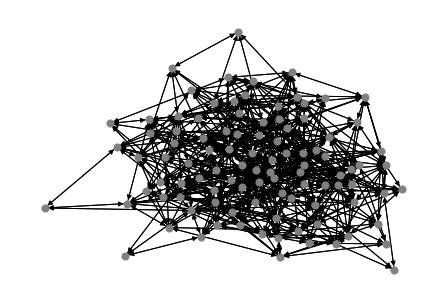

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

N = 100  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()

In [3]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

In [4]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In [5]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

In [6]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

In [7]:
def pagerank_naive(g):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

In [8]:
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

In [9]:
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [10]:
for k in range(K):
    # Uncomment the corresponding line to select different version.
    # pagerank_naive(g)
    # pagerank_batch(g)
    # pagerank_level2(g)
    pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0139, 0.0147, 0.0103, 0.0102, 0.0134, 0.0098, 0.0166, 0.0124, 0.0084,
        0.0084, 0.0068, 0.0090, 0.0042, 0.0093, 0.0059, 0.0108, 0.0118, 0.0109,
        0.0050, 0.0075, 0.0133, 0.0147, 0.0117, 0.0096, 0.0117, 0.0083, 0.0110,
        0.0125, 0.0075, 0.0074, 0.0093, 0.0099, 0.0133, 0.0065, 0.0101, 0.0122,
        0.0091, 0.0176, 0.0090, 0.0083, 0.0073, 0.0101, 0.0119, 0.0151, 0.0134,
        0.0119, 0.0101, 0.0082, 0.0110, 0.0109, 0.0134, 0.0135, 0.0119, 0.0075,
        0.0123, 0.0094, 0.0092, 0.0132, 0.0101, 0.0040, 0.0090, 0.0065, 0.0077,
        0.0094, 0.0082, 0.0102, 0.0097, 0.0074, 0.0066, 0.0108, 0.0116, 0.0096,
        0.0082, 0.0057, 0.0117, 0.0100, 0.0042, 0.0118, 0.0074, 0.0101, 0.0058,
        0.0101, 0.0133, 0.0124, 0.0116, 0.0101, 0.0100, 0.0094, 0.0101, 0.0090,
        0.0101, 0.0105, 0.0084, 0.0074, 0.0117, 0.0066, 0.0145, 0.0091, 0.0099,
        0.0076])
